*ACTIVITY 7.01*: EXTRACTING THE TOP 100 E-BOOKS FROM GUTENBERG

Project Gutenberg encourages the creation and distribution of eBooks by encouraging volunteer efforts to digitize and archive cultural works. This activity aims to scrape the URL of Project Gutenberg's Top 100 eBooks to identify the eBooks' links. It uses BeautifulSoup to parse the HTML and regular expression code to identify the Top 100 eBook file numbers. You can use these numbers to download the book into your local drive if you want.

In [34]:
# Step 1: Import the necessary libraries
import requests
from bs4 import BeautifulSoup
import re

# Step 2: Read the HTML from the URL
url = "https://www.gutenberg.org/browse/scores/top"
response = requests.get(url)

# Step 3: Function to check the status of the web request
def check_request_status(response):
    if response.status_code == 200:
        print("Request successful!")
    else:
        print(f"Request failed with status code: {response.status_code}")

check_request_status(response)

# Step 4: Decode the response and pass to BeautifulSoup
soup = BeautifulSoup(response.content, 'html.parser')

# Step 5: Find all href tags and print first 30 elements
all_links = [a['href'] for a in soup.find_all('a', href=True)]
print("\nFirst 30 href elements:")
print(all_links[:30])

# Step 6: Use regex to find numeric digits (file numbers)
file_numbers = []
for link in all_links:
    matches = re.findall(r'/ebooks/(\d+)', link)
    if matches:
        file_numbers.extend(matches)

# Step 7: Initialize list for top 100 file numbers
top_100_file_numbers = file_numbers[:100]
print("\nFirst 10 file numbers found:")
print(top_100_file_numbers[:10])

# Step 8: Examine soup object's text (first 2000 chars)
print("\nFirst 2000 characters of soup text:")
print(soup.text[:2000])

# Step 9-13: Find and print the top 100 eBook names using your working method
print("\nExtracting top 100 titles...")
top_100_section = soup.find('h2', string='Top 100 EBooks yesterday')
if not top_100_section:
    print("Could not find 'Top 100 EBooks yesterday' section.")
else:
    # Extract the parent element (usually a <div> or <ol>)
    list_container = top_100_section.find_next('ol')  # Try <ol> first
    if not list_container:
        list_container = top_100_section.find_next('ul')  # Fallback to <ul>
    
    if list_container:
        # Extract all list items (<li>)
        book_items = list_container.find_all('li', limit=100)
        top_100_titles = []
        
        for item in book_items:
            title = item.get_text(strip=True)
            # Clean up the title (remove download counts, e.g., "(1234)")
            title = re.sub(r'\(\d+\)$', '', title).strip()
            top_100_titles.append(title)
        
        # Step 13: Print the list of titles
        print("\nTop 100 eBook Titles:")
        for i, title in enumerate(top_100_titles, 1):
            print(f"{i}. {title}")
        
        # Bonus: Combine with file numbers if counts match
        if len(top_100_titles) == len(top_100_file_numbers):
            print("\nFirst 5 eBooks with file numbers:")
            for i in range(5):
                print(f"{top_100_titles[i]} (File: {top_100_file_numbers[i]})")
        else:
            print("\nWarning: Mismatch between titles and file numbers count")
    else:
        print("Could not find the list of eBooks.")

Request successful!

First 30 href elements:
['/', '/donate/', '/about/', '/about/contact_information.html', '/about/background/', '/help/mobile.html', '/help/', '/ebooks/offline_catalogs.html', '/donate/', '/browse/scores/top', '/ebooks/categories', '/ebooks/bookshelf/', '/ebooks/', '/browse/scores/top', '/ebooks/categories', '/about/pretty-pictures.html', '#books-last1', '#authors-last1', '#books-last7', '#authors-last7', '#books-last30', '#authors-last30', '/ebooks/2641', '/ebooks/2701', '/ebooks/100', '/ebooks/17157', '/ebooks/158', '/ebooks/1513', '/ebooks/16389', '/ebooks/84']

First 10 file numbers found:
['2641', '2701', '100', '17157', '158', '1513', '16389', '84', '6593', '394']

First 2000 characters of soup text:




Top 100 | Project Gutenberg





































X

Go!







 Donate 





About▼

About Project Gutenberg 
Contact Us
History & Philosophy
Kindle & eReaders
Help Pages
Offline Catalogs
Donate



Frequently Downloaded
Main Categories
Reading L

*ACTIVITY 7.02*: BUILDING YOUR OWN MOVIE DATABASE BY READING AN API 

In this activity, you will build a complete movie database by communicating and interfacing with a free API from the OMDb portal http://www.omdbapi.com/. You will obtain a unique user key from the OMDb website that must be used when your program tries to access the API. Then, you will need to store this key value in a .json file.

The aims of this activity are as follows:
- To retrieve and print basic data about a movie (the title is entered by the user) from the web (the OMDb database).
- If a poster of the movie can be found, download the file and save it in a user-specified location.

In [40]:
# Step 1: Import required libraries
import urllib.request
import urllib.parse
import urllib.error
import json
import os

# Step 5 & 6: Configure API with the provided key
API_URL = "http://www.omdbapi.com/"
API_KEY = "bf55a02b"  # Using the provided API key
API_KEY_PARAM = f"&apikey={API_KEY}"

# Step 7: Utility function to print JSON movie data
def print_json(data):
    """Pretty print movie data from JSON"""
    if data.get('Response') == 'False':
        print("Error:", data.get('Error', 'Unknown error'))
        return
    
    print("\nMovie Information:")
    print("------------------")
    print(f"Title: {data.get('Title', 'N/A')}")
    print(f"Year: {data.get('Year', 'N/A')}")
    print(f"Rated: {data.get('Rated', 'N/A')}")
    print(f"Runtime: {data.get('Runtime', 'N/A')}")
    print(f"Genre: {data.get('Genre', 'N/A')}")
    print(f"Director: {data.get('Director', 'N/A')}")
    print(f"Actors: {data.get('Actors', 'N/A')}")
    print(f"Plot: {data.get('Plot', 'N/A')}")
    print(f"IMDb Rating: {data.get('imdbRating', 'N/A')}")
    print(f"Poster Available: {'Yes' if data.get('Poster', 'N/A') != 'N/A' else 'No'}")

# Step 8: Utility function to download movie poster
def download_poster(poster_url, save_path):
    """Download and save movie poster"""
    if poster_url == 'N/A':
        print("No poster available for this movie.")
        return False
    
    try:
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        
        # Download and save the poster
        urllib.request.urlretrieve(poster_url, save_path)
        print(f"Poster saved successfully at {save_path}")
        return True
    except Exception as e:
        print(f"Error downloading poster: {e}")
        return False

# Main function to search for movies
def search_movie():
    """Main function to search for movie and handle operations"""
    # Get user input
    movie_title = input("Enter movie title: ")
    save_location = input("Enter poster save location: ").strip()
    
    # Prepare API request
    params = {
        't': movie_title,
        'r': 'json'
    }
    query_string = urllib.parse.urlencode(params)
    full_url = f"{API_URL}?{query_string}{API_KEY_PARAM}"
    
    try:
        # Make API request
        print(f"\nSearching for '{movie_title}'...")
        with urllib.request.urlopen(full_url) as response:
            data = json.loads(response.read().decode('utf-8'))
        
        # Print movie information
        print_json(data)
        
        # Handle poster download
        poster_url = data.get('Poster', 'N/A')
        if poster_url != 'N/A':
            download_choice = input("\nWould you like to download the poster? (y/n): ").lower()
            if download_choice == 'y':
                if not save_location:
                    save_path = f"{movie_title}_poster.jpg"
                else:
                    save_path = os.path.join(save_location, f"{movie_title}_poster.jpg")
                
                download_poster(poster_url, save_path)
    
    except urllib.error.URLError as e:
        print(f"Error connecting to OMDb API: {e}")
    except json.JSONDecodeError:
        print("Error parsing API response")

# Run the program
if __name__ == "__main__":
    print("Movie Database using OMDb API")
    print("----------------------------")
    search_movie()

Movie Database using OMDb API
----------------------------


Enter movie title:  titanic
Enter poster save location:  C:\Users\danie\Downloads



Searching for 'titanic'...

Movie Information:
------------------
Title: Titanic
Year: 1997
Rated: PG-13
Runtime: 194 min
Genre: Drama, Romance
Director: James Cameron
Actors: Leonardo DiCaprio, Kate Winslet, Billy Zane
Plot: A seventeen-year-old aristocrat falls in love with a kind but poor artist aboard the luxurious, ill-fated R.M.S. Titanic.
IMDb Rating: 7.9
Poster Available: Yes



Would you like to download the poster? (y/n):  n


*Exercise 3* Connect to an API of your choice and do a simple data pull - you can use any API - except the API you have selected for your project. Connect to the API and do a "Get" call/operation on the API to return a subset of data from the API 

In [42]:
# This Python script connects to the USDA FoodData Central API to search for nutritional data.

import requests

# Set up API parameters
api_key = "UUF9sHP8bgDpBV1k3a6a1eWMK02C5CNnwXCBnvJT"
base_url = "https://api.nal.usda.gov/fdc/v1"
search_term = "Cheddar Cheese"

# Make GET request to search endpoint
response = requests.get(
    f"{base_url}/foods/search",
    params={
        "api_key": api_key,
        "query": search_term,
        "pageSize": 5  # Limit to 5 results
    }
)

# Check if request was successful
if response.status_code == 200:
    data = response.json()
    print(f"Found {len(data['foods'])} results for '{search_term}':")
    for food in data['foods']:
        print(f"- {food['description']} (ID: {food['fdcId']})")
else:
    print(f"Error: {response.status_code} - {response.text}")

Found 5 results for 'Cheddar Cheese':
- CHEDDAR CHEESE (ID: 2057648)
- CHEDDAR CHEESE (ID: 2015943)
- CHEDDAR CHEESE (ID: 2118224)
- CHEDDAR CHEESE (ID: 2021597)
- CHEDDAR CHEESE (ID: 2116771)


*Exercise 4* Using one of the datasets provided in Weeks 5 & 6, or a dataset of your own, choose 3 of the following visualizations to complete. You must submit via PDF along with your code. You are free to use Matplotlib, Seaborn or another package if you prefer.

C:\Users\danie\AppData\Local\Temp\ipykernel_16492\3884883816.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=joy_counts.values, y=joy_counts.index, palette='viridis')


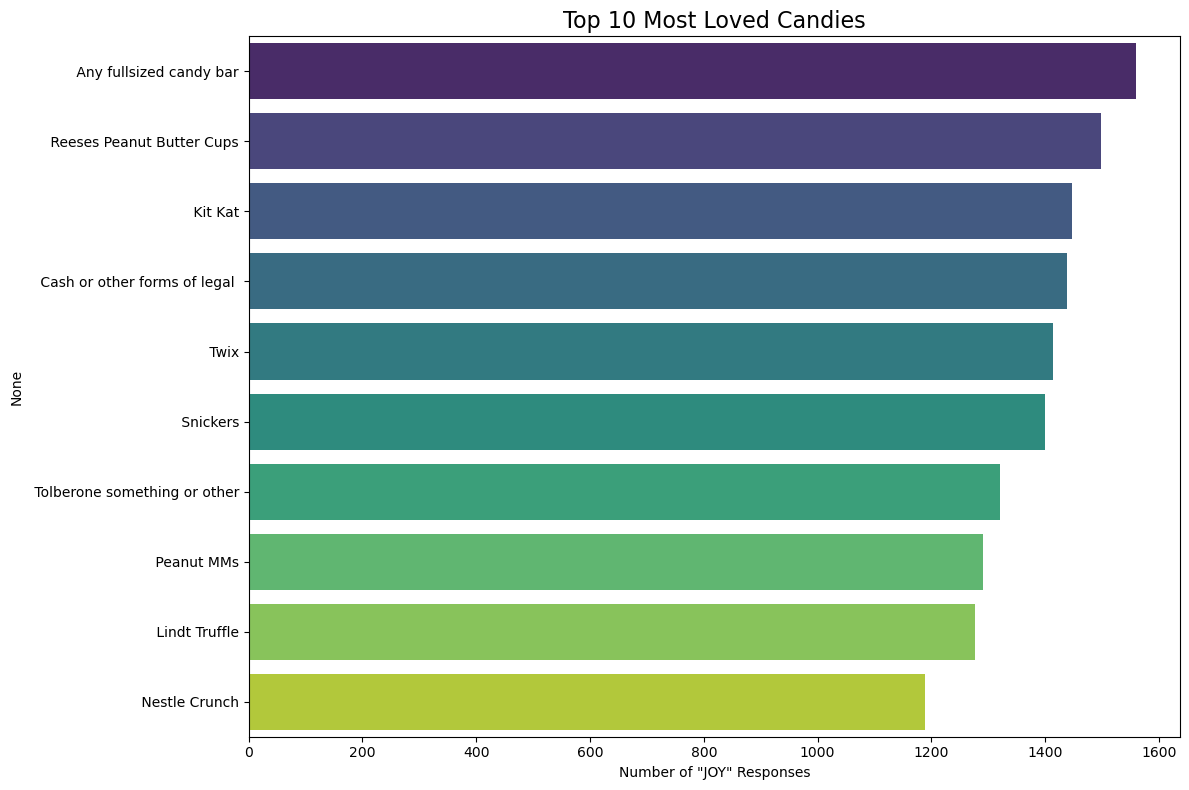

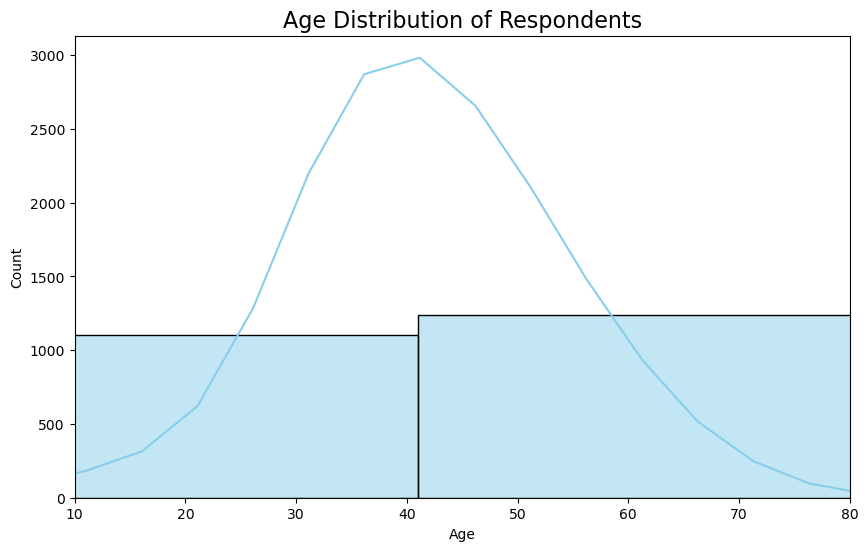

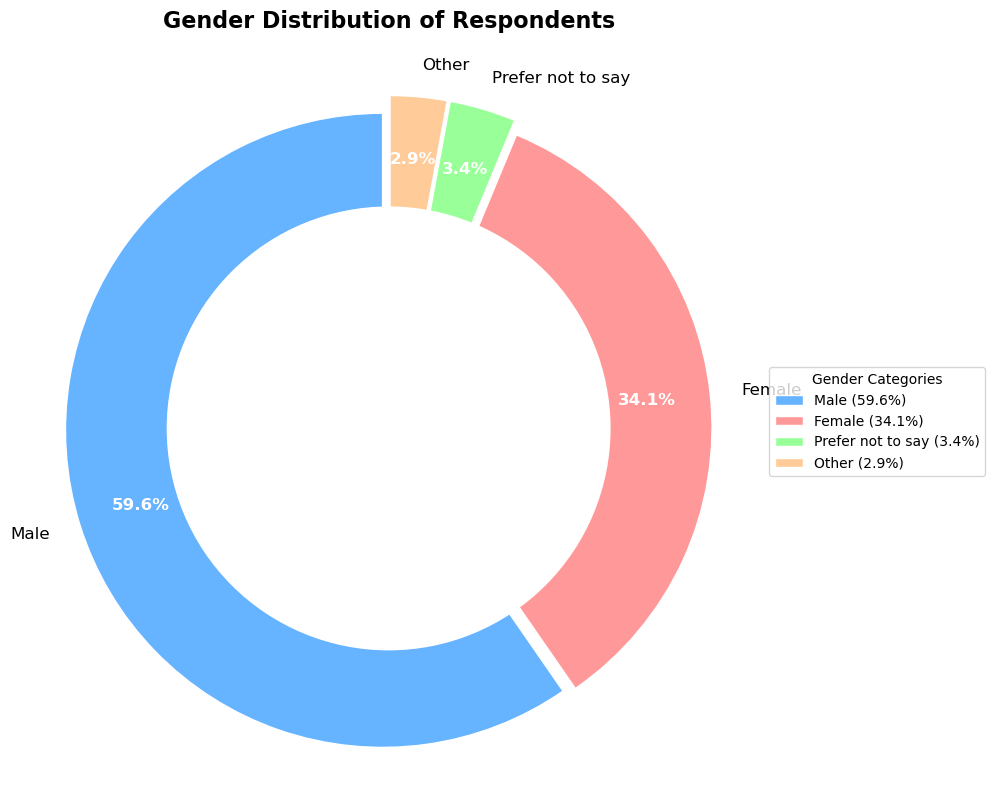

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset with proper encoding handling
try:
    candy = pd.read_csv('candyhierarchy2017.csv', encoding='latin1')  # or 'ISO-8859-1'
except UnicodeDecodeError:
    try:
        candy = pd.read_csv('candyhierarchy2017.csv', encoding='cp1252')
    except Exception as e:
        print(f"Failed to read file: {e}")
        raise

# Data Cleaning
# Fix age column (handling non-numeric values)
candy['Q3: AGE'] = pd.to_numeric(candy['Q3: AGE'], errors='coerce')

# Clean column names (remove special characters)
candy.columns = candy.columns.str.replace(r'[^a-zA-Z0-9: ]', '', regex=True)

# Visualization 1: Top 10 Candies (Bar Chart)
plt.figure(figsize=(12, 8))
candy_ratings = candy.filter(like='Q6')
joy_counts = candy_ratings.apply(lambda x: x[x == 'JOY'].count()).sort_values(ascending=False)[:10]
joy_counts.index = joy_counts.index.str.replace('Q6 ', '').str[:30]  # Shorten long names

sns.barplot(x=joy_counts.values, y=joy_counts.index, palette='viridis')
plt.title('Top 10 Most Loved Candies', fontsize=16)
plt.xlabel('Number of "JOY" Responses')
plt.tight_layout()
plt.savefig('top_candies.png', bbox_inches='tight')
plt.show()

# Visualization 2: Age Distribution (Histogram)
plt.figure(figsize=(10, 6))
age_data = candy['Q3: AGE'].dropna()
sns.histplot(age_data, bins=25, kde=True, color='skyblue')
plt.title('Age Distribution of Respondents', fontsize=16)
plt.xlabel('Age')
plt.xlim(10, 80)
plt.savefig('age_distribution.png', bbox_inches='tight')
plt.show()

# Visualization 3: Gender Distribution (Pie Chart)
# Data Cleaning for Gender Visualization
# Standardize gender categories
gender_mapping = {
    'Male': 'Male',
    'male': 'Male',
    'M': 'Male',
    'Female': 'Female',
    'female': 'Female',
    'F': 'Female',
    'I\'d rather not say': 'Prefer not to say',
    'I would rather not say': 'Prefer not to say'
}

candy['Q2: GENDER'] = candy['Q2: GENDER'].str.strip().map(gender_mapping).fillna('Other')

# Visualization 
plt.figure(figsize=(10, 8))
gender_counts = candy['Q2: GENDER'].value_counts()

# Custom colors and explode for emphasis
colors = ['#66b3ff', '#ff9999', '#99ff99', '#ffcc99']
explode = (0.02, 0.02, 0.05, 0.05)  # Slightly emphasize the smaller categories

# Create pie chart with improved formatting
patches, texts, autotexts = plt.pie(
    gender_counts,
    labels=gender_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=explode,
    pctdistance=0.8,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1},
    textprops={'fontsize': 12}
)

# Make percentages white and bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_weight('bold')

# Add a donut hole
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures pie is drawn as a circle
plt.axis('equal')  
plt.title('Gender Distribution of Respondents\n', fontsize=16, fontweight='bold')

# Add legend with percentages
legend_labels = [f'{label} ({pct})' for label, pct in zip(
    gender_counts.index,
    [f'{p:.1f}%' for p in (gender_counts/gender_counts.sum())*100]
)]
plt.legend(legend_labels, title="Gender Categories", 
           loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig('gender_distribution_enhanced.png', dpi=300, bbox_inches='tight')
plt.show()